In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

In [128]:
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import torch
import clip
import random

In [1]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [2]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-fyphjuqo
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-fyphjuqo
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 567662b0fd33ca4b022d94d3b8de896628cd32dd
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36610 sha256=a5b91a8ba4dec1c3a89dbd48ef6f78e999eb58e4256ae26c33591cce0a194221
  Stored in directory: /tmp/pip-ephem-wheel-cache-hzqsjni5/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [3]:
!pip install -q jupyter_bbox_widget dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.2/56.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 46.9 MB/s eta 0:00:00


In [180]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [6]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


Setup SAM

In [9]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [10]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

Setup CLIP

In [78]:
model, preprocess = clip.load("ViT-B/32", device=DEVICE)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 131MiB/s]


In [11]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [181]:
import os

IMAGE_NAME = "/content/drive/MyDrive/cats.jpg" #if you dont have this image, search up an image of something, upload to your drive, then copy path here
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

In [182]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb) 

In [183]:
print(sam_result[0].keys()) #--> SAM different outputs --> BBOX is what we need for the crop

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


We used automatic mask generator so it will try to mask the WHOLE image.

The result will be a list of dictionaries, where the dictionary is a mask and its keys represent different info about the mask

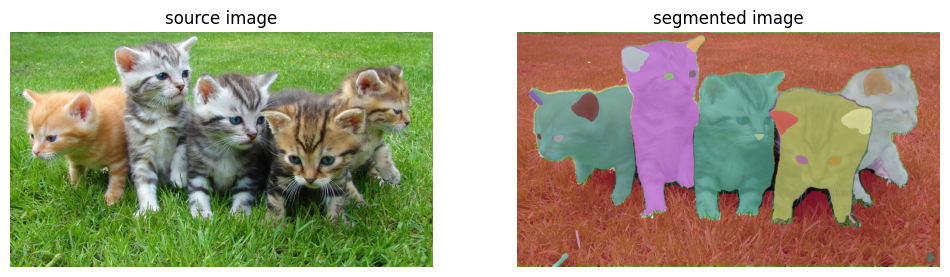

In [184]:
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Function for cropping the image with the mask to send to CLIP

In [185]:
def crop_image(image, mask):
    x, y, w, h = mask["bbox"]
    masked = image * np.expand_dims(mask["segmentation"], -1)
    crop = masked[y : y + h, x : x + w]
    if h > w:
        top, bottom, left, right = 0, 0, (h - w) // 2, (h - w) // 2
    else:
        top, bottom, left, right = (w - h) // 2, (w - h) // 2, 0, 0
    # padding
    crop = cv2.copyMakeBorder(
        crop,
        top,
        bottom,
        left,
        right,
        cv2.BORDER_CONSTANT,
        value=(0, 0, 0),
    )

    crop = PIL.Image.fromarray(crop)
    return crop

### Function for CLIP scoring stuff

In [186]:
def score(text, cropimage):
  image = preprocess(cropimage).unsqueeze(0).to(DEVICE)
  text = clip.tokenize([text, "background"]).to(DEVICE)

  with torch.no_grad():
      image_features = model.encode_image(image)
      text_features = model.encode_text(text)
      
      logits_per_image, logits_per_text = model(image, text)
      probs = logits_per_image.softmax(dim=-1).cpu().numpy()

  return probs[0,0]

### Function for drawing a mask at the end

In [187]:
def draw_masks(image, masks, alpha = 0.7):
    for mask in masks:
        color = [random.randint(127, 255) for _ in range(3)]

        # draw mask overlay
        colored_mask = np.expand_dims(mask["segmentation"], 0).repeat(3, axis=0)
        colored_mask = np.moveaxis(colored_mask, 0, -1)
        masked = np.ma.MaskedArray(image, mask=colored_mask, fill_value=color)
        image_overlay = masked.filled()
        image = cv2.addWeighted(image, 1 - alpha, image_overlay, alpha, 0)

        # draw contour
        contours, _ = cv2.findContours(
            np.uint8(mask["segmentation"]), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )
        cv2.drawContours(image, contours, -1, (0, 0, 255), 1)
    return PIL.Image.fromarray(image)

### All cropped masks

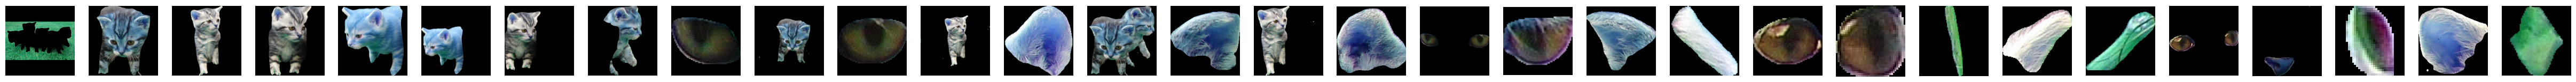

In [188]:
seg_array = [[crop_image(image_bgr, i), i] for i in sam_result]

num_images = len(seg_array)
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))

# Loop through each image and display it on its corresponding subplot
for i in range(num_images):
    axes[i].imshow(seg_array[i][0]) #get cropped images
    axes[i].axis('off')

# Show the figure
plt.show()


### Iterate through this array and CLIP score all of them based on inputted word, return the segmentations with the highest score

would you like to change image sir

In [197]:
ipt1 = input("Segment this: ") 
#i[0] is cropped image i[1] is mask
scores = {score(ipt1, i[0]):i[1] for i in seg_array}
#sort list
allscores = sorted(scores.keys(), reverse=True)


Segment this: cat eyes


select top-n matching segmentations out of 31 generated segmentations --> n:5


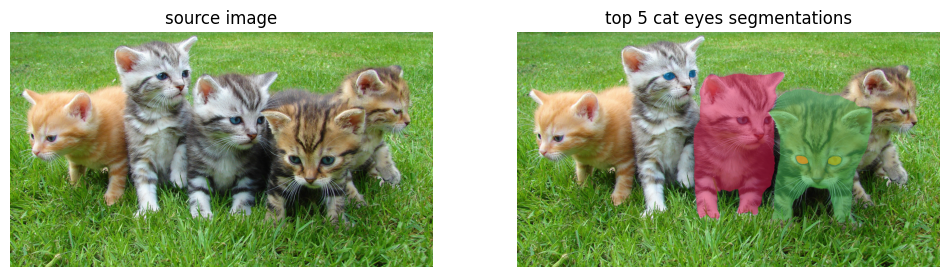

In [198]:
ipt2 = input(f"select top-n matching segmentations out of {len(seg_array)} generated segmentations --> n:")
ipt2 = int(ipt2)
selectedsegmentations = [scores[i] for i in allscores[:ipt2]] # get masks

detections = sv.Detections.from_sam(sam_result=selectedsegmentations)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', f'top {ipt2} {ipt1} segmentations']
)

